In [1]:
# Standard imports
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True})
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
from tqdm import tqdm

The code in this notebook is adapted from the paper "A Unified Framework for Optimization-Based
Graph Coarsening\" by Kumar et. al (2023).

# Graph Coarsening Algorithm

In [2]:
class FGC:
    def __init__(self, L, X, n, gamma, lambd, alpha, seed = 666):
        # Save parameter fields.
        self.L = L
        self.X = X
        self.N = X.shape[0]
        self.n = n
        self.d = X.shape[1]
        
        # Initialize optimization variables as random matrices.
        np.random.seed(seed)
        self.X_tilde = np.random.normal(0, 1, (self.n, self.d))
        
        self.clip = 1e-10
        self.C = np.random.normal(0, 1, (self.N, self.n))
        self.C[self.C < self.clip] = self.clip

        # Save regularization variables.
        self.alpha = alpha
        self.lambd = lambd
        self.gamma = gamma
        
        # Optimization parameters.
        self.num_iter = 0
        self.lr = 1e-5
        self.num_c_iter = 100

    def objective(self):
        f = 0
        
        # Bregman divergence.
        J = np.outer(np.ones(self.n), np.ones(self.n)) / self.n
        f += -self.gamma * np.linalg.slogdet(self.C.T @ self.L @ self.C + J)[1]
        
        # Dirichlet energy.
        L_tilde = self.C.T @ self.L @ self.C
        f += np.trace(self.X_tilde.T @ L_tilde @ self.X_tilde)

        # Regularization for C.
        f += self.lambd * np.linalg.norm(self.C @ np.ones((self.n, 1)))**2 / 2
        
        # Regularization for X_tilde.
        f += self.alpha * np.linalg.norm(self.X - self.C @ self.X_tilde)**2 / 2
        
        return f

    def update_X_tilde(self):
        L_tilde = self.C.T @ self.L @ self.C
        A = 2 * L_tilde / self.alpha + self.C.T @ self.C
        self.X_tilde = np.linalg.pinv(A) @ self.C.T @ X

        for i in range(len(self.X_tilde)):
            self.X_tilde[i] = self.X_tilde[i] / np.linalg.norm(self.X_tilde[i])
        
        return None

    def gradient_C(self):
        grad = np.zeros(self.C.shape)
        
        J = np.outer(np.ones(self.n), np.ones(self.n)) / self.n
        v = np.linalg.pinv(self.C.T @ self.L @ self.C + J)
        grad += -2*self.gamma * self.L @ self.C @ v
        
        grad += self.alpha * (self.C @ self.X_tilde - self.X) @ self.X_tilde.T
        grad += 2*self.L @ self.C @ self.X_tilde @ self.X_tilde.T
        grad += self.lambd * np.abs(self.C) @ (np.ones((self.n, self.n)))

        return grad

    def update_C(self):
        self.C = self.C - self.lr * self.gradient_C()
        self.C[self.C < self.clip] = self.clip

        for i in range(len(self.C)):
            self.C[i] = self.C[i] / np.linalg.norm(self.C[i],1)
        
        return None

    def fit(self, num_iters):
        loss = np.zeros(num_iters)
        for i in tqdm(range(num_iters)):
            for _ in range(self.num_c_iter):
                self.update_C()
            self.update_X_tilde()
            loss[i] = self.objective()
            self.num_iter += 1
        return (self.C, self.X_tilde, loss)

In [3]:
class GC:
    def __init__(self, L, n, gamma, lambd, alpha, seed = 666, quiet = False):
        # Save parameter fields.
        self.L = L
        self.N = L.shape[0]
        self.n = n
        
        # Initialize optimization variables as random matrices.
        self.clip = 1e-10
        self.C = np.random.normal(0, 1, (self.N, self.n))
        self.C[self.C < self.clip] = self.clip

        # Save regularization variables.
        self.alpha = alpha
        self.lambd = lambd
        self.gamma = gamma
        
        # Optimization parameters.
        self.num_iter = 0
        self.lr = 1e-5
        self.num_c_iter = 100
        
        # Turn off tqdm output.
        self.quiet = quiet

    def objective(self):
        f = 0
        
        # Bregman divergence.
        J = np.outer(np.ones(self.n), np.ones(self.n)) / self.n
        f += -self.gamma * np.linalg.slogdet(self.C.T @ self.L @ self.C + J)[1]

        # Regularization for C.
        f += self.lambd * np.linalg.norm(self.C @ np.ones((self.n, 1)))**2 / 2
        
        return f

    def gradient_C(self):
        grad = np.zeros(self.C.shape)
        
        J = np.outer(np.ones(self.n), np.ones(self.n)) / self.n
        v = np.linalg.pinv(self.C.T @ self.L @ self.C + J)
        grad += -2*self.gamma * self.L @ self.C @ v
        grad += self.lambd * np.abs(self.C) @ (np.ones((self.n, self.n)))

        return grad

    def update_C(self):
        self.C = self.C - self.lr * self.gradient_C()
        self.C[self.C < self.clip] = self.clip

        for i in range(len(self.C)):
            self.C[i] = self.C[i] / np.linalg.norm(self.C[i],1)
        
        return None

    def fit(self, num_iters):
        loss = np.zeros(num_iters)
        for i in tqdm(range(num_iters), disable = self.quiet):
            for _ in range(self.num_c_iter):
                self.update_C()
            loss[i] = self.objective()
            self.num_iter += 1
        return (self.C, loss)

# Generate Random Data

In [4]:
def make_LX(G, d, seed = None):
    # Create edge weights
    np.random.seed(seed)
    N = len(G.nodes)
    W = np.zeros((N, N))
    for (x, y) in G.edges:
        W[x][y] = np.random.randint(1,10)
    W = W + W.T

    # Compute Laplacian
    D = np.diag(W @ np.ones((W.shape[0])))
    L = D - W

    # Create features for the synthetic graph
    X = np.random.multivariate_normal(np.zeros(N), np.linalg.pinv(L), d).T
    
    return L, X

def make_erdos_renyi_graph(N, p, d, seed = None):
    G = nx.erdos_renyi_graph(N, p, directed = False)
    return make_LX(G, d, seed)

def make_barabasi_albert_graph(N, m, d, seed = None):
    G = nx.barabasi_albert_graph(n = N, m = m, seed = seed)
    return make_LX(G, d, seed)

def make_watts_strogatz_graph(N, k, p, d, seed = None):
    G = nx.watts_strogatz_graph(N, k, p, seed = seed)
    return make_LX(G, d, seed)

def make_random_geometric_graph(N, r, d, seed = None):
    # Make graph
    G = nx.random_geometric_graph(N, r, seed = seed)
    return make_LX(G, d, seed)

In [5]:
def reconstruction_error(L, L_hat):
    return np.linalg.norm(L - L_hat)

In [6]:
L, X = make_erdos_renyi_graph(100, 0.1, 500)
#L, X = make_barabasi_albert_graph(N, 20, 500)
#L, X = make_watts_strogatz_graph(N, 20, 0.1, 500)
#L, X = make_barabasi_albert_graph(N, 20, 500)
#L, X = make_random_geometric_graph(100, 0.1, 500)

In [7]:
n = 10
num_iter = 100

fgc = FGC(L, X, n, 500, 500, X.shape[1]/2) 
C, X_t, loss = fgc.fit(num_iter)

100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


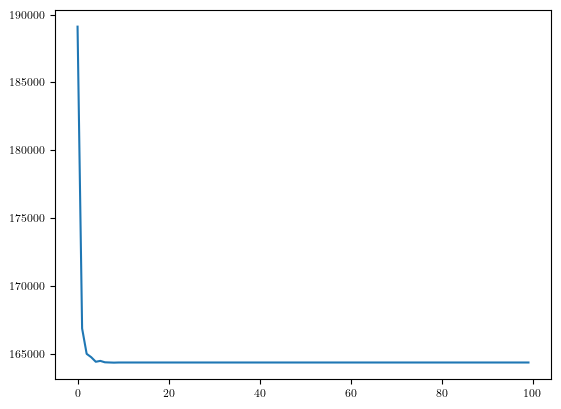

In [8]:
plt.plot(loss)

In [9]:
# Reconstruction error
P = np.linalg.pinv(C)
CP = C @ P
np.linalg.norm(L - CP.T @ L @ CP)

521.1367751750371

In [10]:
n = 10
num_iter = 100

gc = GC(L, n, 500, 500, X.shape[1]/2) 
C, loss = gc.fit(num_iter)

100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


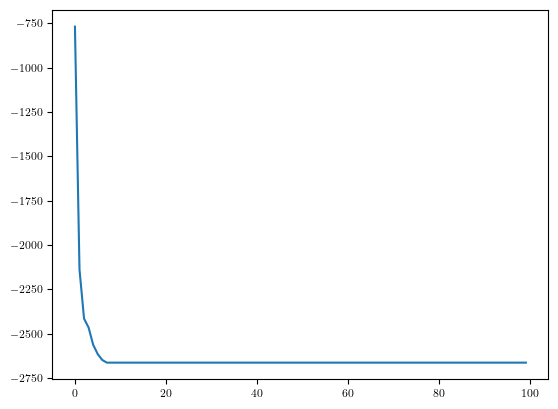

In [11]:
plt.plot(loss)

In [12]:
# Reconstruction error
P = np.linalg.pinv(C)
CP = C @ P
np.linalg.norm(L - CP.T @ L @ CP)

522.1161674466674

In [13]:
N = 100
p = 0.1
d = 500

n = 10
num_iter = 100

fgc_err = np.zeros(10)
gc_err = np.zeros(10)
for i in range(10):
    L, X = make_erdos_renyi_graph(N, p, d)
    fgc = FGC(L, X, n, 500, 500, d/2) 
    C, X_t, loss = fgc.fit(num_iter)
    P = np.linalg.pinv(C)
    CP = C @ P
    fgc_err[i] = reconstruction_error(L, CP.T @ L @ CP)
    print(round(fgc_err[i], 2), end = '\t')
    
    gc = GC(L, n, 500, 500, d/2) 
    C, loss = gc.fit(num_iter)
    P = np.linalg.pinv(C)
    CP = C @ P
    gc_err[i] = reconstruction_error(L, CP.T @ L @ CP)
    print(round(gc_err[i], 2))
    print()

100%|██████████| 100/100 [00:13<00:00,  7.65it/s]


502.91	

100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


506.86



100%|██████████| 100/100 [00:12<00:00,  7.76it/s]


506.79	

100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


508.43



100%|██████████| 100/100 [00:13<00:00,  7.62it/s]


526.06	

100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


526.71



100%|██████████| 100/100 [00:12<00:00,  7.69it/s]


523.08	

100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


525.97



100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


517.2	

100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


519.26



100%|██████████| 100/100 [00:13<00:00,  7.67it/s]


509.09	

100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


515.32



100%|██████████| 100/100 [00:13<00:00,  7.67it/s]


534.75	

100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


533.23



100%|██████████| 100/100 [00:13<00:00,  7.69it/s]


551.39	

100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


553.69



100%|██████████| 100/100 [00:12<00:00,  7.79it/s]


528.96	

100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


531.7



100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


513.5	

100%|██████████| 100/100 [00:08<00:00, 11.79it/s]

516.54



# Clustering Coefficients

In [14]:
N = 100
p = 0.1

C_ER = np.zeros(5000)
for i in range(5000):
    G = nx.erdos_renyi_graph(N, p, directed = False)
    C_ER[i] = nx.average_clustering(G)

In [15]:
N = 100
m = 20

C_BA = np.zeros(5000)
for i in range(5000):
    G = nx.barabasi_albert_graph(n = N, m = m)
    C_BA[i] = nx.average_clustering(G)

In [16]:
N = 100
k = 20
p = 0.1

C_WS = np.zeros(5000)
for i in range(5000):
    G = nx.watts_strogatz_graph(N, k, p)
    C_WS[i] = nx.average_clustering(G)

In [17]:
N = 100
r = 0.1

C_RG = np.zeros(5000)
for i in range(5000):
    G = nx.random_geometric_graph(N, r)
    C_RG[i] = nx.average_clustering(G)

In [18]:
np.mean(C_ER), np.mean(C_BA), np.mean(C_WS), np.mean(C_RG)

(0.10031190066156255,
 0.42637837955990837,
 0.5444442049660247,
 0.47006800421800415)

# Experiment Results

In [19]:
er_diffs = np.load('results/er_diff.npy')
ba_diffs = np.load('results/ba_diff.npy')
ws_diffs = np.load('results/ws_diff.npy')
rg_diffs = np.load('results/rg_diff.npy')

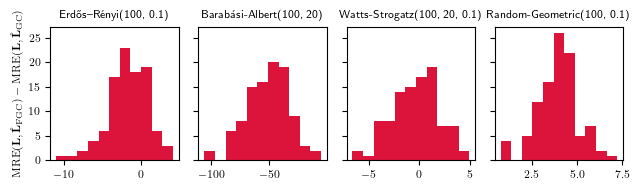

In [20]:
fig, axs = plt.subplots(1, 4, figsize = (6.5, 2), sharey = True)

axs[0].hist(er_diffs, color = 'crimson', bins = 11)
axs[0].set_ylabel(r'${\rm MRE}(\mathbf{L}, \hat{\mathbf{L}}_{\rm FGC}) - {\rm MRE}(\mathbf{L}, \hat{\mathbf{L}}_{\rm GC})$', size = 8)
axs[0].set_title(r'Erdős–Rényi(100, 0.1)', size = 8)

axs[1].hist(ba_diffs, color = 'crimson', bins = 11)
axs[1].set_title(r'Barabási-Albert(100, 20)', size = 8)

axs[2].hist(ws_diffs, color = 'crimson', bins = 11)
axs[2].set_title(r'Watts-Strogatz(100, 20, 0.1)', size = 8)

axs[3].hist(rg_diffs, color = 'crimson', bins = 11)
axs[3].set_title(r'Random-Geometric(100, 0.1)', size = 8)

fig.tight_layout()
plt.savefig('hists.pdf', bbox_inches = 'tight')